In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import sys
from p5lib import *
import pickle
import os.path

%matplotlib inline

### Load and preprocess data

The method ```preprocess_data``` chooses only the selected potential features and combine some columns that are mutually exclusive (such as 4 year college and < 4 year college). It also removes data that does not have Completion or Retention data because those are the target features. 

The result from preprocessing is stored in a pickle file so we can reload it much faster. 

In [2]:
pickle_file = 'reduced_data.pickle'
if os.path.isfile(pickle_file):
    data = pickle.load(open(pickle_file, "rb"))
else:
    data = pd.read_csv('MERGED2013_PP.csv')
    # print data.shape
    data = preprocess_data(data)
    pickle.dump(data, open(pickle_file, "wb"))

print data.shape

(6007, 45)


### Split data into features and targets (X and y) 

We also get rid of data that are outliers (data with retention rate 0)

In [3]:
X = data[['CONTROL', 'DEBT_MDN', 'DEP_INC_AVG', 'GRAD_DEBT_MDN', 'IND_INC_AVG', 'INEXPFTE', 'PAR_ED_PCT_1STGEN', 
          'PAR_ED_PCT_HS', 'PAR_ED_PCT_MS', 'PAR_ED_PCT_PS', 'PCTFLOAN', 'PCTPELL', 'UG25abv', 'UGDS', 
          'WDRAW_DEBT_MDN', 'L4_COLLEGE', 'NPT4', 'NUM4', 
          'PFTFTUG1_EF', 'PFTFAC',
          'SAT_AVG_ALL', 'ACTCMMID', 'ADM_RATE_ALL', 'AVGFACSAL', 'COSTT4_A',
          'CCSIZSET', 'CCUGPROF', 'CCBASIC', # carnegie classification data
          'C150', 'RET_FT']]

# remove noise, this bumps up the r2 score pretty nicely
# X = X[~((X.RET_FT == 0) & (X.C150 > 0.5))]
# X = X[~((X.C150 == 0) & (X.RET_FT > 0.5))]
# X = X[~((X.C150 == 1) & (X.RET_FT < 0.5))]
# X = X[~((X.RET_FT == 1) & (X.C150 < 0.5))]
X = X[~(X.RET_FT == 0)]

y = X[['C150', 'RET_FT']]
X = X.drop('C150', 1)
X = X.drop('RET_FT', 1)
print X.shape
print y.shape
print len(X.dropna())


(5960, 28)
(5960, 2)
1146


### Fill missing values with the means

In [4]:
fill_cols_with_mean = ['DEBT_MDN', 'DEP_INC_AVG', 'GRAD_DEBT_MDN', 'IND_INC_AVG', 'INEXPFTE', 'WDRAW_DEBT_MDN',
                       'PAR_ED_PCT_1STGEN', 'PAR_ED_PCT_HS', 'PAR_ED_PCT_MS', 'PAR_ED_PCT_PS', 'PCTFLOAN', 'PCTPELL', 
                       'UG25abv', 'NPT4', 'NUM4', 'PFTFTUG1_EF', 'PFTFAC', 'SAT_AVG_ALL', 'ACTCMMID', 'ADM_RATE_ALL', 
                       'AVGFACSAL', 'COSTT4_A']

for col in fill_cols_with_mean:
    if col in X:
        X[col] = X[col].fillna(X[col].mean())

In [5]:
print_num_data_for_each_features(X)

Number of available data for each feature (not counting the NaN values)
CONTROL             Control (public/private)                      5960
DEBT_MDN            Median debt                                   5960
DEP_INC_AVG         Avg income dependent stu                      5960
GRAD_DEBT_MDN       Median debt complete                          5960
IND_INC_AVG         Avg income independent stu                    5960
INEXPFTE            Expense per FTE student                       5960
PAR_ED_PCT_1STGEN   % 1st gen students                            5960
PAR_ED_PCT_HS       % parent education high school                5960
PAR_ED_PCT_MS       % parent education middle school              5960
PAR_ED_PCT_PS       % parent education post secondary             5960
PCTFLOAN            % Fed student loan                            5960
PCTPELL             % Pell Grant receiver                         5960
UG25abv             % undergrad > 25 yr                           5960
UGDS 

### Scale data

Process non-categorical data using standard scaler so they all have 0 means. 

In [6]:
from sklearn import preprocessing

# take features of type cost/money, and percentage (between 0 and 1) and preprocess with standard scaler
# and then use these preprocessed features for PCA
tmpX = X[['DEBT_MDN', 'DEP_INC_AVG', 'GRAD_DEBT_MDN', 'IND_INC_AVG', 'INEXPFTE', 'UGDS', 'WDRAW_DEBT_MDN', 'NPT4', 
          'NUM4', 'SAT_AVG_ALL', 'ACTCMMID', 'AVGFACSAL', 'COSTT4_A',
          'PAR_ED_PCT_1STGEN', 'PAR_ED_PCT_HS', 'PAR_ED_PCT_MS', 'PAR_ED_PCT_PS', 'PCTFLOAN', 'PCTPELL', 'UG25abv', 
          'PFTFTUG1_EF', 'PFTFAC', 'ADM_RATE_ALL'
         ]]

scaler = preprocessing.StandardScaler()

scaledX = scaler.fit_transform(tmpX)
print scaledX.shape


(5960, 23)


### Use PCA for dimensional reduction

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=scaledX.shape[1])
pca.fit(scaledX)

print pca.explained_variance_ratio_

[  3.27172733e-01   1.23599811e-01   9.71482969e-02   6.85430501e-02
   5.78347093e-02   4.73881578e-02   4.19985272e-02   3.92640360e-02
   3.46822758e-02   2.76923933e-02   2.50142190e-02   2.22809791e-02
   2.20554011e-02   1.60944642e-02   1.16668152e-02   9.24339709e-03
   7.56805099e-03   7.34731055e-03   4.92884099e-03   4.55383044e-03
   2.99018233e-03   6.09843373e-04   3.22675391e-04]


In [8]:
pca = PCA(n_components=15)
pca.fit(scaledX)
reducedX = pca.transform(scaledX)

# reducedX is the chosen top PCA components
print reducedX.shape

(5960, 15)


### Add categorical features as one hot encoded

In [9]:
tmp1X = np.array(pd.get_dummies(X['CONTROL']))
tmp2X = X['L4_COLLEGE'].astype(int)
tmp2X = np.reshape(tmp2X, (len(tmp2X), 1)) 

tmp3X = np.array(pd.get_dummies(X['CCSIZSET']))
tmp4X = np.array(pd.get_dummies(X['CCUGPROF']))
tmp5X = np.array(pd.get_dummies(X['CCBASIC']))

print reducedX.shape
print tmp1X.shape, tmp2X.shape, tmp3X.shape, tmp4X.shape, tmp5X.shape

finalX = np.concatenate((reducedX, tmp1X, tmp2X, tmp3X, tmp4X, tmp5X), axis=1)

print finalX.shape

(5960, 15)
(5960, 3) (5960, 1) (5960, 17) (5960, 14) (5960, 33)
(5960, 83)


### Train / test split

Optionally store the train/test split in a pickle file if we want to keep the same train/test data. In order to do this, comment out the os.remove line. 

(4768, 83)
(1192, 83)
(4768, 2)
(1192, 2)
       y_test c150  y_train c150
count  1192.000000   4768.000000
mean      0.535155      0.525585
std       0.243068      0.235768
min       0.000000      0.000000
25%       0.341786      0.335755
50%       0.560828      0.550759
75%       0.729782      0.714300
max       1.000000      1.000000
        y_test ret  y_train ret
count  1192.000000  4768.000000
mean      0.697389     0.698303
std       0.177281     0.166123
min       0.019200     0.047100
25%       0.587525     0.591775
50%       0.714300     0.708300
75%       0.821525     0.818200
max       1.000000     1.000000


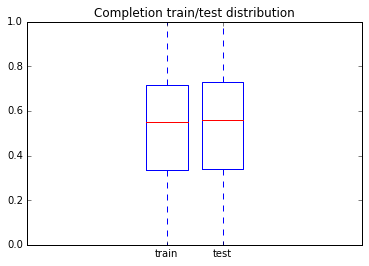

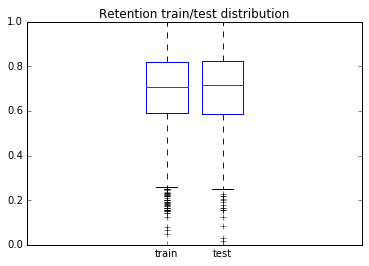

In [10]:
from sklearn import cross_validation as cv

pickle_file = 'm5-split_data.pickle'

os.remove(pickle_file) # clear cache (delete pickle). Comment this out to keep the same train/test data over multiple runs
if os.path.isfile(pickle_file):
    print "loading split_data from pickle"
    split_data = pickle.load(open(pickle_file, "rb"))
    X_train, X_test, y_train, y_test = split_data['X_train'], split_data['X_test'], split_data['y_train'], split_data['y_test']
else:
    y = np.array(y)
    X_train, X_test, y_train, y_test = cv.train_test_split(finalX, y, train_size=0.8)
    split_data = {
        'X_train': X_train,
        'X_test':  X_test,
        'y_train': y_train,
        'y_test':  y_test,        
    }
    pickle.dump(split_data, open(pickle_file, "wb"))

print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

# Check if the train / test has similar distribution
print pd.DataFrame(data={'y_train c150': pd.Series(y_train[:,0]).describe(),
                         'y_test c150': pd.Series(y_test[:,0]).describe(),
                        })
print pd.DataFrame(data={'y_train ret': pd.Series(y_train[:,1]).describe(),
                         'y_test ret': pd.Series(y_test[:,1]).describe(),
                        })
plt.title("Completion train/test distribution")
plt.boxplot([y_train[:,0], y_test[:,0]], labels=['train', 'test'], positions=[0.2, 0.4])
plt.show()
plt.title("Retention train/test distribution")
plt.boxplot([y_train[:,1], y_test[:,1]], labels=['train', 'test'], positions=[0.2, 0.4])
plt.show()


## Build models

### Decision Tree

--- R2 Completion ---
best params: {'max_depth': 6}
R2 score on train data: 0.623693704628
R2 score on test  data: 0.526445674649
--- R2 Retention ---
best params: {'max_depth': 5}
R2 score on train data: 0.291045932344
R2 score on test  data: 0.236519777126
--- MSE Completion ---
MSE on train data: 0.020913151556
MSE on test  data: 0.0279550633228
--- MSE Retention ---
MSE on train data: 0.0195606824045
MSE on test  data: 0.0239748308887
--- MAE Completion ---
MAE on train data: 0.10677896531
MAE on test  data: 0.122207917129
--- MAE Retention ---
MAE on train data: 0.101779738261
MAE on test  data: 0.110685018522


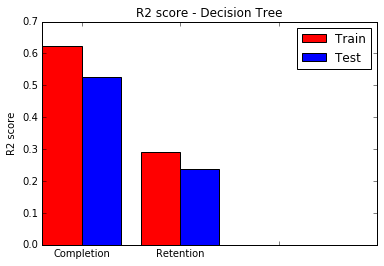

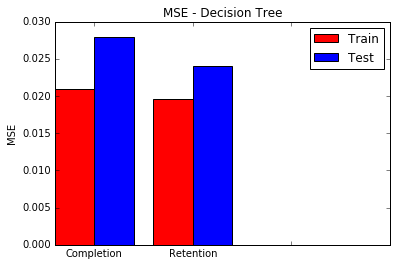

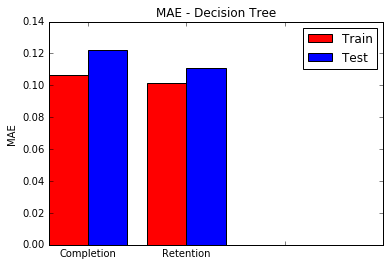

In [11]:
DT19_model = build_DecisionTree_model(X_train[:,:19], X_test[:,:19], y_train, y_test)

--- R2 Completion ---
best params: {'max_depth': 9}
R2 score on train data: 0.748041366242
R2 score on test  data: 0.511529262431
--- R2 Retention ---
best params: {'max_depth': 5}
R2 score on train data: 0.292646594761
R2 score on test  data: 0.241288072922
--- MSE Completion ---
MSE on train data: 0.0140025536602
MSE on test  data: 0.0288356154069
--- MSE Retention ---
MSE on train data: 0.0195165186842
MSE on test  data: 0.0238250967084
--- MAE Completion ---
MAE on train data: 0.0846722371558
MAE on test  data: 0.121282194736
--- MAE Retention ---
MAE on train data: 0.101584348397
MAE on test  data: 0.110140376178


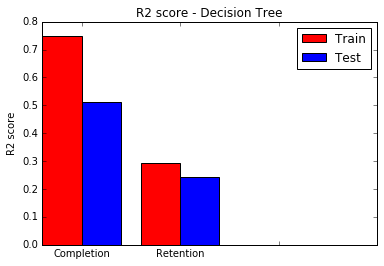

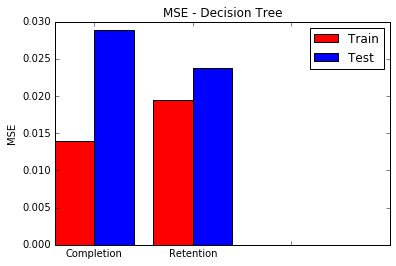

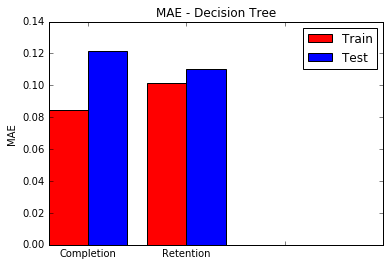

In [12]:
DT_model = build_DecisionTree_model(X_train, X_test, y_train, y_test)

### SVR

--- R2 Completion ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.730913171566
R2 score on test  data: 0.664967845755
--- R2 Retention ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.461338086074
R2 score on test  data: 0.320818389028
--- MSE Completion ---
MSE on train data: 0.0149544498564
MSE on test  data: 0.0197777627312
--- MSE Retention ---
MSE on train data: 0.0148621682312
MSE on test  data: 0.0213276831251
--- MAE Completion ---
MAE on train data: 0.0932859442512
MAE on test  data: 0.105447527209
--- MAE Retention ---
MAE on train data: 0.0887895701618
MAE on test  data: 0.102405861544


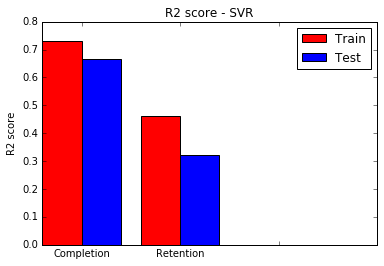

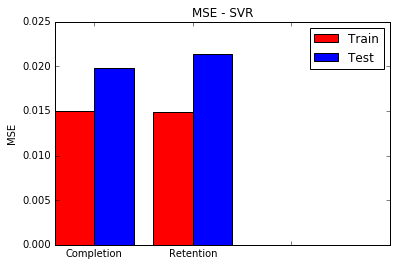

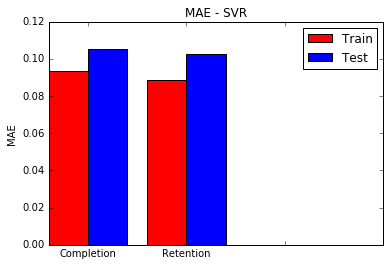

In [13]:
SVR19_model = build_SVR_model(X_train[:,:19], X_test[:,:19], y_train, y_test)

--- R2 Completion ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.750416639012
R2 score on test  data: 0.664534591664
--- R2 Retention ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.486145911087
R2 score on test  data: 0.310574807947
--- MSE Completion ---
MSE on train data: 0.013870548323
MSE on test  data: 0.0198033387737
--- MSE Retention ---
MSE on train data: 0.0141776979554
MSE on test  data: 0.0216493523927
--- MAE Completion ---
MAE on train data: 0.0902493628444
MAE on test  data: 0.106106979288
--- MAE Retention ---
MAE on train data: 0.0870624822088
MAE on test  data: 0.103092037647


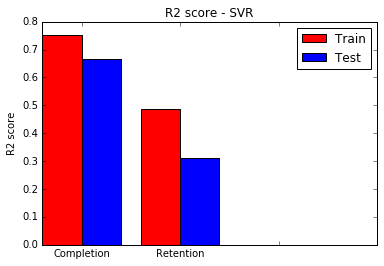

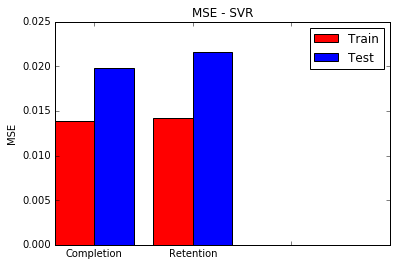

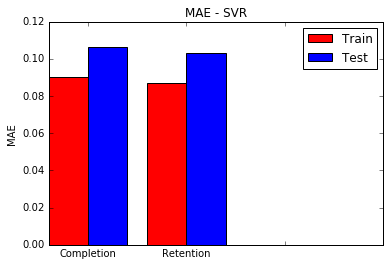

In [14]:
SVR_model = build_SVR_model(X_train, X_test, y_train, y_test)

### KNN

--- R2 Completion ---
best params: {'n_neighbors': 13}
R2 score on train data: 0.714485083812
R2 score on test  data: 0.676576518377
--- R2 Retention ---
best params: {'n_neighbors': 18}
R2 score on train data: 0.41159160545
R2 score on test  data: 0.310834749854
--- MSE Completion ---
MSE on train data: 0.015867437742
MSE on test  data: 0.0190924745585
--- MSE Retention ---
MSE on train data: 0.0162347185171
MSE on test  data: 0.0216411896885
--- MAE Completion ---
MAE on train data: 0.0915115218225
MAE on test  data: 0.100742294847
--- MAE Retention ---
MAE on train data: 0.0906409768829
MAE on test  data: 0.100801412192


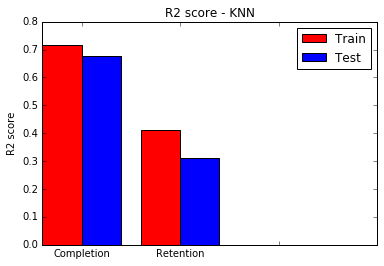

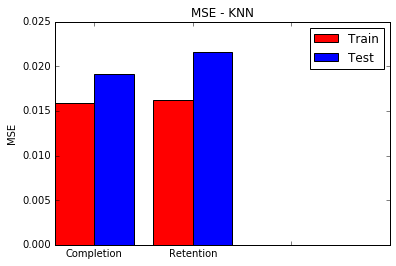

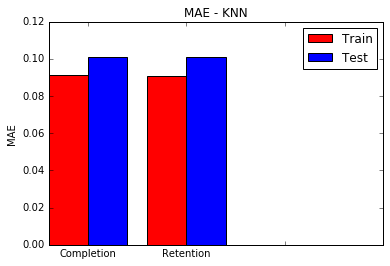

In [15]:
KNN19_model = build_KNN_model(X_train[:,:19], X_test[:,:19], y_train, y_test)

--- R2 Completion ---
best params: {'n_neighbors': 11}
R2 score on train data: 0.722851954387
R2 score on test  data: 0.675234578804
--- R2 Retention ---
best params: {'n_neighbors': 11}
R2 score on train data: 0.45158297646
R2 score on test  data: 0.304284161394
--- MSE Completion ---
MSE on train data: 0.0154024504842
MSE on test  data: 0.0191716925146
--- MSE Retention ---
MSE on train data: 0.0151313205073
MSE on test  data: 0.0218468914812
--- MAE Completion ---
MAE on train data: 0.0894863073363
MAE on test  data: 0.0994312478851
--- MAE Retention ---
MAE on train data: 0.0867756177547
MAE on test  data: 0.101258755339


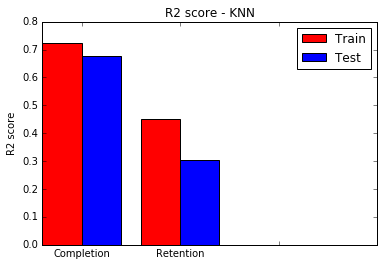

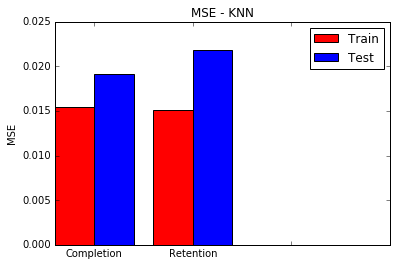

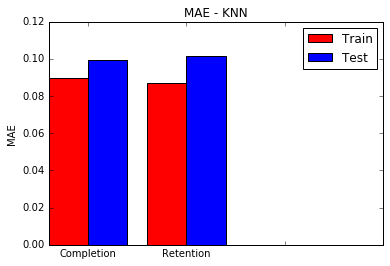

In [16]:
KNN_model = build_KNN_model(X_train, X_test, y_train, y_test)

### Random Forest

--- R2 Completion ---
R2 score on train data: 0.949663372483
R2 score on test  data: 0.66026065963
--- R2 Retention ---
R2 score on train data: 0.90381773334
R2 score on test  data: 0.290042802831
--- MSE Completion ---
MSE on train data: 0.00279744860246
MSE on test  data: 0.0200556393741
--- MSE Retention ---
MSE on train data: 0.00265375552088
MSE on test  data: 0.0222940990878
--- MAE Completion ---
MAE on train data: 0.0381734816423
MAE on test  data: 0.104463029108
--- MAE Retention ---
MAE on train data: 0.0361949388619
MAE on test  data: 0.104172408104


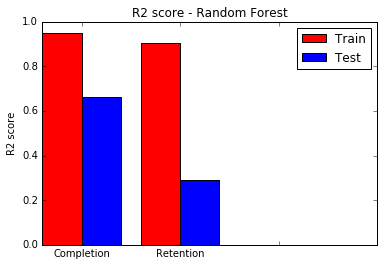

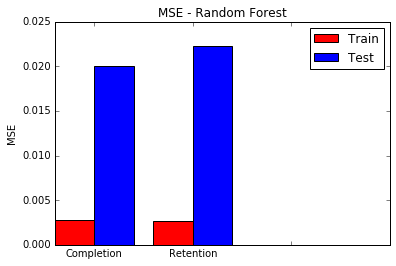

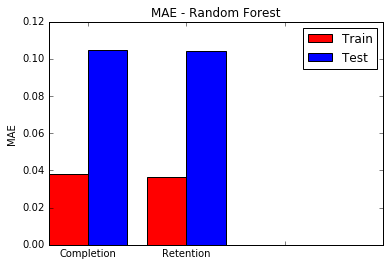

In [17]:
RF19_model = build_RandomForest_model(X_train[:,:19], X_test[:,:19], y_train, y_test, n_estimators=50)

--- R2 Completion ---
R2 score on train data: 0.951243533231
R2 score on test  data: 0.677309951775
--- R2 Retention ---
R2 score on train data: 0.904670299244
R2 score on test  data: 0.303823020157
--- MSE Completion ---
MSE on train data: 0.00270963146623
MSE on test  data: 0.0190491782017
--- MSE Retention ---
MSE on train data: 0.00263023245831
MSE on test  data: 0.0218613722534
--- MAE Completion ---
MAE on train data: 0.0369398656774
MAE on test  data: 0.101245780083
--- MAE Retention ---
MAE on train data: 0.0359883028816
MAE on test  data: 0.101925130469


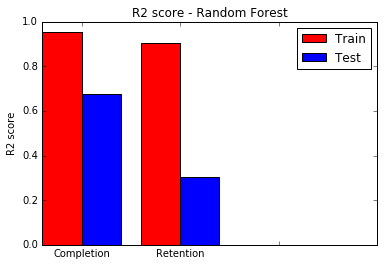

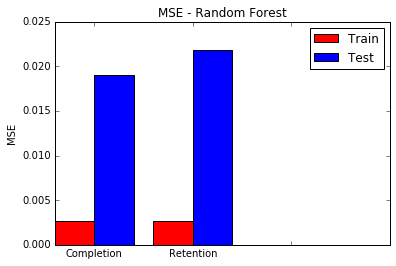

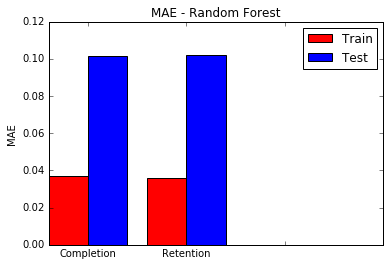

In [18]:
RF_model = build_RandomForest_model(X_train, X_test, y_train, y_test, n_estimators=50)

### Comparing R2, MSE and MAE between models with 19 features

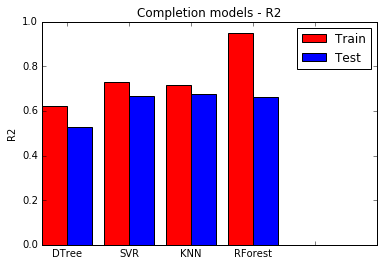

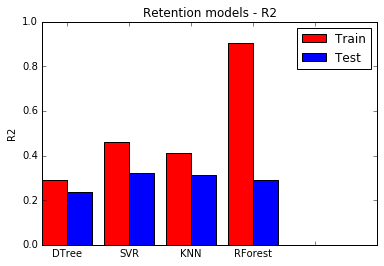

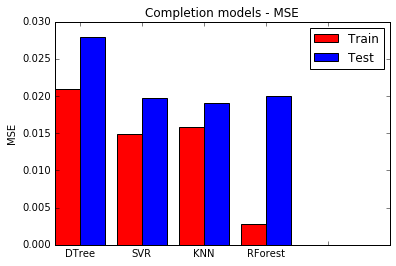

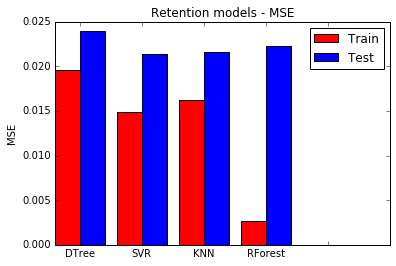

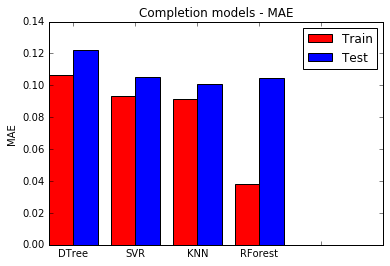

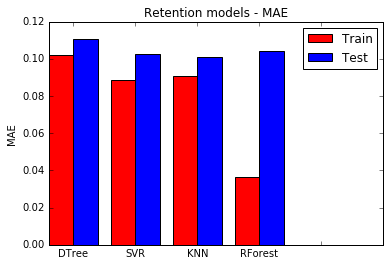

In [19]:
plot_compare_metric([DT19_model, SVR19_model, KNN19_model, RF19_model], 
                    ['DTree', 'SVR', 'KNN', 'RForest'], 
                    metric='r2')
plot_compare_metric([DT19_model, SVR19_model, KNN19_model, RF19_model], 
                    ['DTree', 'SVR', 'KNN', 'RForest'], 
                    metric='mse')
plot_compare_metric([DT19_model, SVR19_model, KNN19_model, RF19_model], 
                    ['DTree', 'SVR', 'KNN', 'RForest'], 
                    metric='mae')
    

### Comparing R2, MSE and MAE between models with 83 features

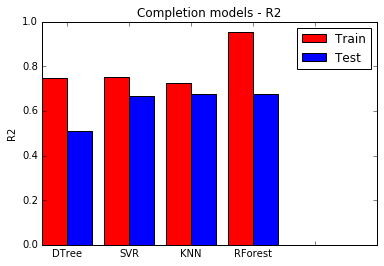

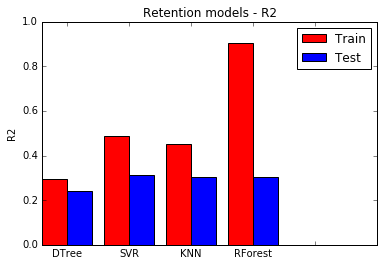

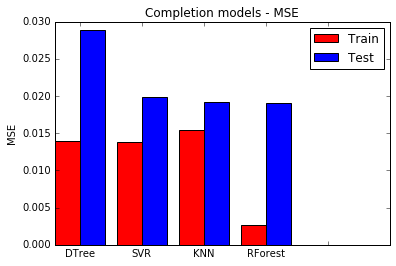

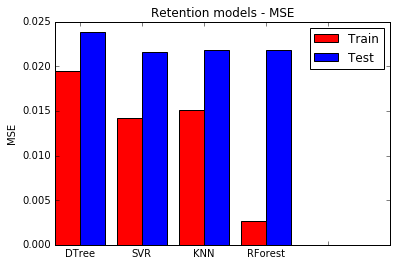

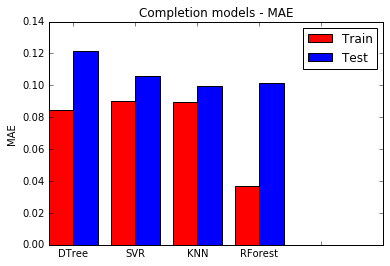

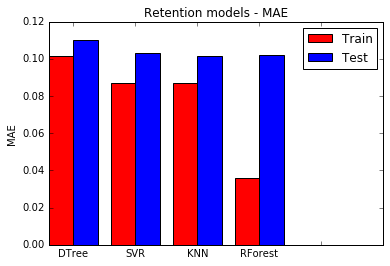

In [20]:
plot_compare_metric([DT_model, SVR_model, KNN_model, RF_model], 
                    ['DTree', 'SVR', 'KNN', 'RForest'], 
                    metric='r2')
plot_compare_metric([DT_model, SVR_model, KNN_model, RF_model], 
                    ['DTree', 'SVR', 'KNN', 'RForest'], 
                    metric='mse')
plot_compare_metric([DT_model, SVR_model, KNN_model, RF_model], 
                    ['DTree', 'SVR', 'KNN', 'RForest'], 
                    metric='mae')

### Comparing R2, MSE, MAE on test data between models with 19 and 83 features

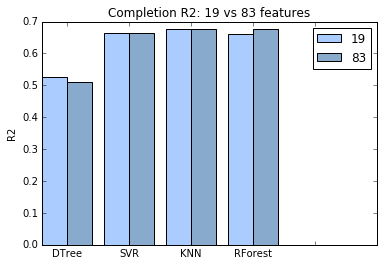

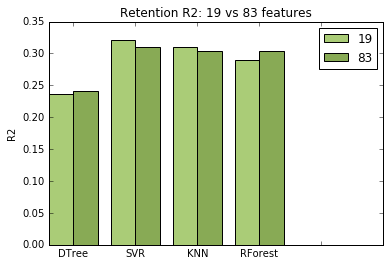

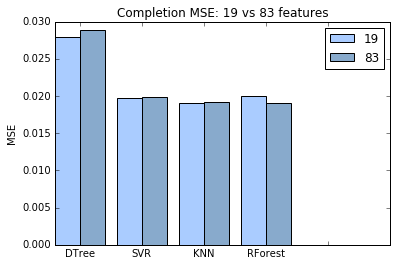

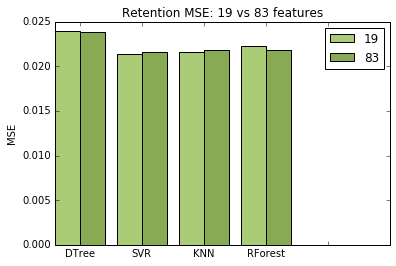

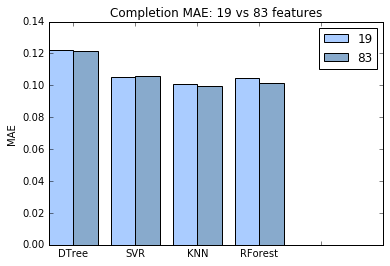

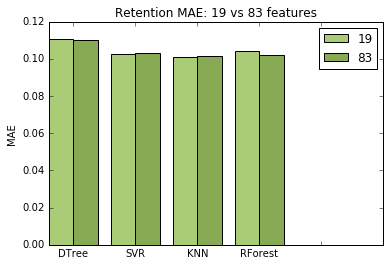

In [21]:
plot_model_improvement([DT19_model, SVR19_model, KNN19_model, RF19_model], 
                       [DT_model, SVR_model, KNN_model, RF_model],
                       ['DTree', 'SVR', 'KNN', 'RForest'],
                       metric='r2')
plot_model_improvement([DT19_model, SVR19_model, KNN19_model, RF19_model], 
                       [DT_model, SVR_model, KNN_model, RF_model],
                       ['DTree', 'SVR', 'KNN', 'RForest'],
                       metric='mse')
plot_model_improvement([DT19_model, SVR19_model, KNN19_model, RF19_model], 
                       [DT_model, SVR_model, KNN_model, RF_model],
                       ['DTree', 'SVR', 'KNN', 'RForest'],
                       metric='mae')

### Using Completion model to help predict Retention rate

Because the Completion model has a pretty good r2 score compared to the Retention model, we could use the Completion model to help predict the Retention. This might work because there is a clear positive linear correlation between completion and retention.

For this improvement, the implementation for the completion model is exactly the same. However, the retention model will have one more feature--the completion rate. The retention model is trained using the same X_train + y1_train (the completion rate data). When doing prediction on the test set, the retention model takes the X_test + the predicted completion rate from the completion model.

In [22]:
from sklearn.ensemble import RandomForestRegressor

def print_r2_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted):
    print "--- R2 Completion ---"
    if hasattr(reg1, 'best_params_'):
        print "best params: {}".format(reg1.best_params_)
    r2_train_reg1 = print_r2score(reg1, X_train, y1_train)
    r2_test_reg1  = print_r2score(reg1, X_test, y1_test, test=True)
    print "--- R2 Retention ---"
    if hasattr(reg2, 'best_params_'):
        print "best params: {}".format(reg2.best_params_)
    X_train1 = np.concatenate((X_train, reshape_y(y1_train)), axis=1)
    X_test1 = np.concatenate((X_test, reshape_y(y1_test_predicted)), axis=1)
    r2_train_reg2 = print_r2score(reg2, X_train1, y2_train)
    r2_test_reg2  = print_r2score(reg2, X_test1, y2_test, test=True)

    return {'reg1': {'train': r2_train_reg1, 'test': r2_test_reg1 },
            'reg2': {'train': r2_train_reg2, 'test': r2_test_reg2 }}

def print_mse_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted):
    print "--- MSE Completion ---"
    mse_train_reg1 = print_mse(reg1, X_train, y1_train)
    mse_test_reg1 = print_mse(reg1, X_test, y1_test, test=True)
    print "--- MSE Retention ---"
    X_train1 = np.concatenate((X_train, reshape_y(y1_train)), axis=1)
    X_test1 = np.concatenate((X_test, reshape_y(y1_test_predicted)), axis=1)
    mse_train_reg2 = print_mse(reg2, X_train1, y2_train)
    mse_test_reg2 = print_mse(reg2, X_test1, y2_test, test=True)
    
    return {'reg1': {'train': mse_train_reg1, 'test': mse_test_reg1 },
            'reg2': {'train': mse_train_reg2, 'test': mse_test_reg2 }}

def print_mae_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted):
    print "--- MAE Completion ---"
    mae_train_reg1 = print_mae(reg1, X_train, y1_train)
    mae_test_reg1 = print_mae(reg1, X_test, y1_test, test=True)
    print "--- MAE Retention ---"
    X_train1 = np.concatenate((X_train, reshape_y(y1_train)), axis=1)
    X_test1 = np.concatenate((X_test, reshape_y(y1_test_predicted)), axis=1)
    mae_train_reg2 = print_mae(reg2, X_train1, y2_train)
    mae_test_reg2 = print_mae(reg2, X_test1, y2_test, test=True)
    
    return {'reg1': {'train': mae_train_reg1, 'test': mae_test_reg1 },
            'reg2': {'train': mae_train_reg2, 'test': mae_test_reg2 }}

# build the model for Retention (y2) using the Completion data (y1)
# So the Retention model uses the prediction result from the Completion model
# Because we feed the prediction from completion model to the retention model, let's call this nested model
def build_RandomForest_model_nested(X_train, X_test, y_train, y_test, n_estimators=50):
    y1_train, y1_test, y2_train, y2_test = split_y(y_train, y_test)

    reg1 = RandomForestRegressor(n_estimators=n_estimators)
    reg1.fit(X_train, y1_train)

    reg2 = RandomForestRegressor(n_estimators=n_estimators)
    
    X_train1 = np.concatenate((X_train, reshape_y(y1_train)), axis=1)
    reg2.fit(X_train1, y2_train)

    y1_test_predicted = reg1.predict(X_test)
    
    r2 = print_r2_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted)
    mse = print_mse_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted)
    mae = print_mae_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted)
#     plot_err_metric(r2, metric='R2 score', model='Random Forest nested')
#     plot_err_metric(mse, metric='MSE', model='Random Forest nested')
#     plot_err_metric(mae, metric='MAE', model='Random Forest nested')
    
    return {'reg1': reg1, 'reg2': reg2, 'r2': r2, 'mse': mse, 'mae': mae}

RF_nested = build_RandomForest_model_nested(X_train[:,:19], X_test[:,:19], y_train, y_test)


--- R2 Completion ---
R2 score on train data: 0.950695786996
R2 score on test  data: 0.659845786949
--- R2 Retention ---
R2 score on train data: 0.912313122163
R2 score on test  data: 0.311570703441
--- MSE Completion ---
MSE on train data: 0.00274007236017
MSE on test  data: 0.0200801303173
--- MSE Retention ---
MSE on train data: 0.002419360078
MSE on test  data: 0.0216180792499
--- MAE Completion ---
MAE on train data: 0.0377122021588
MAE on test  data: 0.103821224842
--- MAE Retention ---
MAE on train data: 0.03362188768
MAE on test  data: 0.102035605672


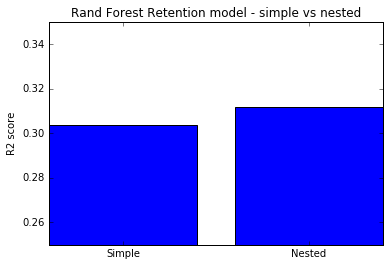

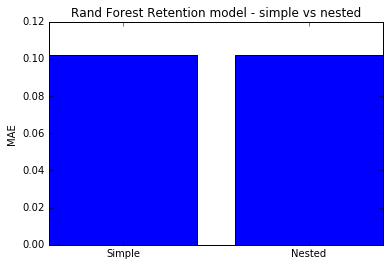

In [23]:
# Comparison of r2 score between simple vs nested model (using RandomForest) 
ret_r2  = [RF_model['r2']['reg2']['test'], RF_nested['r2']['reg2']['test']]
ret_mae  = [RF_model['mae']['reg2']['test'], RF_nested['mae']['reg2']['test']]

plt.title('Rand Forest Retention model - simple vs nested')
ax = plt.subplot(111)
ax.set_ylim([0.25, 0.35])
ax.bar(np.array(range(2)), ret_r2, width=0.8, color='b')
plt.ylabel('R2 score')
plt.xticks(np.array(range(2)) + 0.4, ['Simple', 'Nested'])
plt.show()

plt.title('Rand Forest Retention model - simple vs nested')
ax = plt.subplot(111)
# ax.set_ylim([0.25, 0.50])
ax.bar(np.array(range(2)), ret_mae, width=0.8, color='b')
plt.ylabel('MAE')
plt.xticks(np.array(range(2)) + 0.4, ['Simple', 'Nested'])
plt.show()


### SVR Nested Model

In [24]:
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV

# build the model for Retention (y2) using the Completion data (y1)
# So the Retention model uses the prediction result from the Completion model
# Because we feed the prediction from completion model to the retention model, let's call this nested model
def build_SVR_model_nested(X_train, X_test, y_train, y_test, cv=3, params=None):
    y1_train, y1_test, y2_train, y2_test = split_y(y_train, y_test)

    if params == None:
        params = {'C': np.logspace(-1, 1, 2), 'gamma': np.logspace(-1, 1, 2), 'epsilon': np.logspace(-1, 1, 2)}
    reg = SVR()
    scorer = default_scorer
    reg1 = GridSearchCV(reg, params, scoring=scorer, cv=cv)
    reg1.fit(X_train, y1_train)

    reg = SVR()
    reg2 = GridSearchCV(reg, params, scoring=scorer, cv=cv)
    X_train1 = np.concatenate((X_train, reshape_y(y1_train)), axis=1)
    reg2.fit(X_train1, y2_train)

    y1_test_predicted = reg1.predict(X_test)

    r2 = print_r2_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted)
    mse = print_mse_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted)
    mae = print_mae_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted)

    return {'reg1': reg1, 'reg2': reg2, 'r2': r2, 'mse': mse, 'mae': mae}

SVR_nested = build_SVR_model_nested(X_train[:,:19], X_test[:,:19], y_train, y_test)


--- R2 Completion ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.730913171566
R2 score on test  data: 0.664967845755
--- R2 Retention ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.489728471042
R2 score on test  data: 0.320571304129
--- MSE Completion ---
MSE on train data: 0.0149544498564
MSE on test  data: 0.0197777627312
--- MSE Retention ---
MSE on train data: 0.0140788518938
MSE on test  data: 0.0213354420932
--- MAE Completion ---
MAE on train data: 0.0932859442512
MAE on test  data: 0.105447527209
--- MAE Retention ---
MAE on train data: 0.0853480853023
MAE on test  data: 0.102388513475


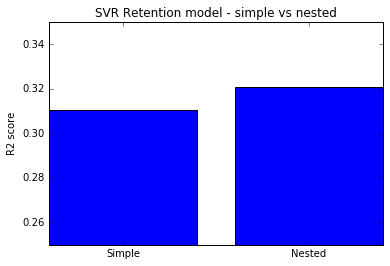

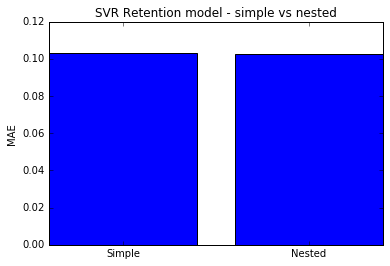

In [25]:
# Comparison of r2 score between simple vs nested model (using SVR model) 
ret_r2  = [SVR_model['r2']['reg2']['test'], SVR_nested['r2']['reg2']['test']]
ret_mae  = [SVR_model['mae']['reg2']['test'], SVR_nested['mae']['reg2']['test']]

plt.title('SVR Retention model - simple vs nested')
ax = plt.subplot(111)
ax.set_ylim([0.25, 0.35])
ax.bar(np.array(range(2)), ret_r2, width=0.8, color='b')

plt.ylabel('R2 score')
plt.xticks(np.array(range(2)) + 0.4, ['Simple', 'Nested'])
plt.show()

plt.title('SVR Retention model - simple vs nested')
ax = plt.subplot(111)
# ax.set_ylim([0.10, 0.11])
ax.bar(np.array(range(2)), ret_mae, width=0.8, color='b')

plt.ylabel('MAE')
plt.xticks(np.array(range(2)) + 0.4, ['Simple', 'Nested'])
plt.show()


### Sensitivity analysis

Sensitivity analysis is done by choosing 100 random data from the training set and changing the input by a little bit to see how different the prediction result for each model is. The difference in prediction result are collected and visualized using whisker plot to see the stability of the model.

Statistical analysis of difference in result when the input have small changes


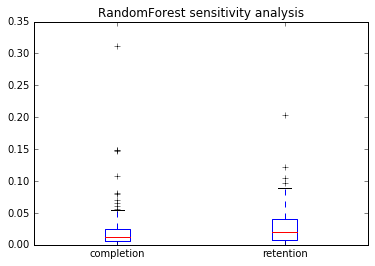

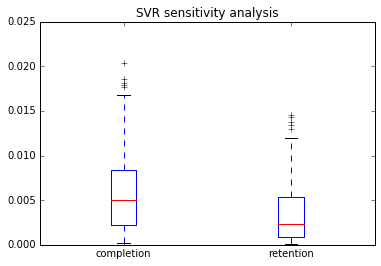

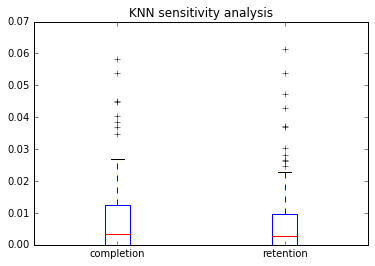

In [26]:

def final_nested_model_predict(reg1, reg2, X):
    y1_predicted = reg1.predict(X)
    X1 = np.concatenate((X, reshape_y(y1_predicted)), axis=1)
    y2_predicted = reg2.predict(X1)
    return y1_predicted, y2_predicted

def final_model_predict(reg1, reg2, X):
    y1_predicted = reg1.predict(X)
    y2_predicted = reg2.predict(X)
    return y1_predicted, y2_predicted

def sensitivity_analysis(reg1, reg2, data, title=''):
    delta_y1, delta_y2 = [], []
    
    for i, row in enumerate(data):
        X_nearby = row.copy()
        for j, a in enumerate(X_nearby):
            span = X_train[:,j].max() - X_train[:,j].min()
            if j < 15:
                X_nearby[j] += span/200

        y1p, y2p = final_model_predict(reg1, reg2, [row]) # predicted value
        y1pn, y2pn = final_model_predict(reg1, reg2, [X_nearby]) # predicted nearby value
        delta_y1.append(abs(y1pn[0] - y1p[0]))
        delta_y2.append(abs(y2pn[0] - y2p[0]))
    
    plt.title("{} sensitivity analysis".format(title))
    plt.boxplot([delta_y1, delta_y2], labels=['completion', 'retention'])
    plt.show()

print "Statistical analysis of difference in result when the input have small changes"
# Just test on a subset of the data (because it's really slow)
X_train_subset = X_train[np.random.choice(len(X_train), 100, replace=False)]

sensitivity_analysis(RF_model['reg1'], RF_model['reg2'], data=X_train_subset, title='RandomForest')
sensitivity_analysis(SVR_model['reg1'], SVR_model['reg2'], data=X_train_subset, title='SVR')
sensitivity_analysis(KNN_model['reg1'], KNN_model['reg2'], data=X_train_subset, title='KNN')


### Prediction error distribution

Metric only goes so far as telling as the mean absolute error, or the R2 score with just one number. 
To get a better idea how our model performs, we'll look at the prediction error on the test data and create histogram of the error distribution, so we can tell what's the percentage the model get it close, and what's the percentage it does really poorly.

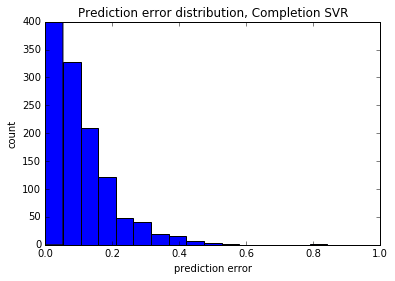

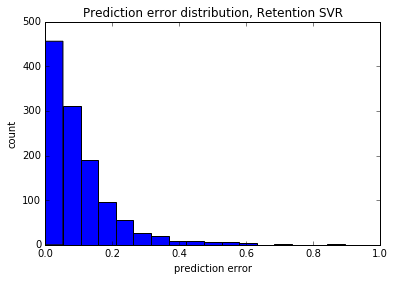

In [27]:
hist_plot_delta(SVR_model, X_test, y_test, model_name='SVR')

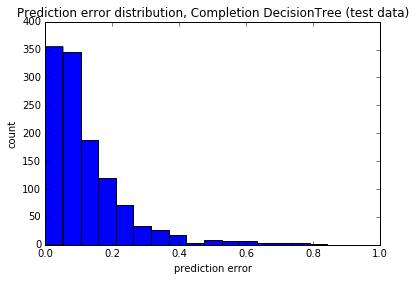

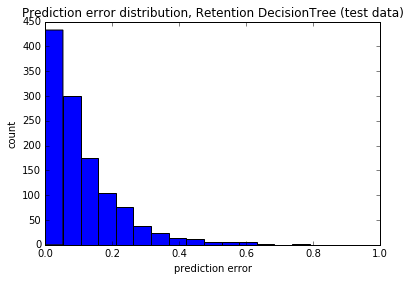

In [28]:
hist_plot_delta(DT_model, X_test, y_test, model_name='DecisionTree (test data)')
# hist_plot_delta(DT_model, X_train, y_train, model_name='DecisionTree (train data)')

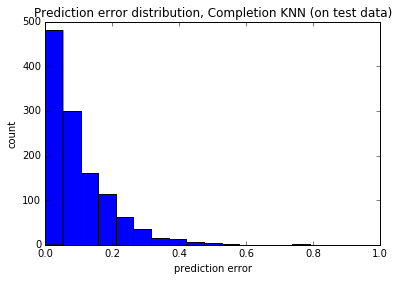

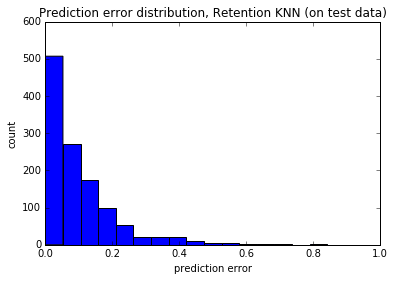

In [29]:
hist_plot_delta(KNN_model, X_test, y_test, model_name='KNN (on test data)')
# hist_plot_delta(KNN_model, X_train, y_train, model_name='KNN (on train data)')

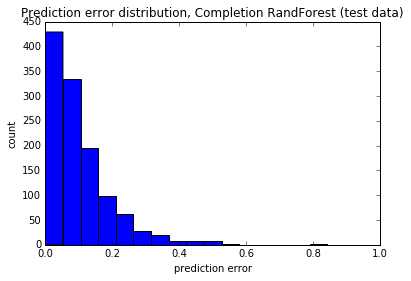

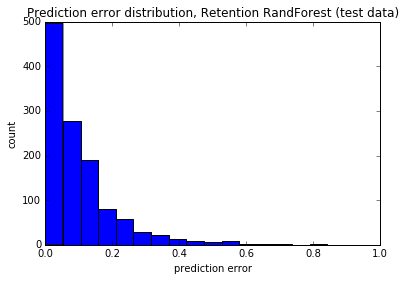

In [30]:
hist_plot_delta(RF_model, X_test, y_test, model_name='RandForest (test data)')
# hist_plot_delta(RF_model, X_train, y_train, model_name='RandForest (train data)')

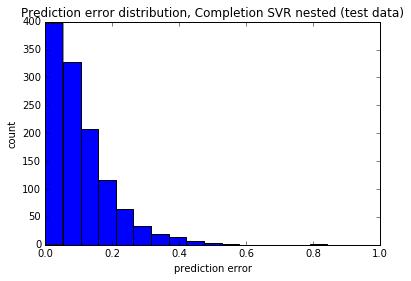

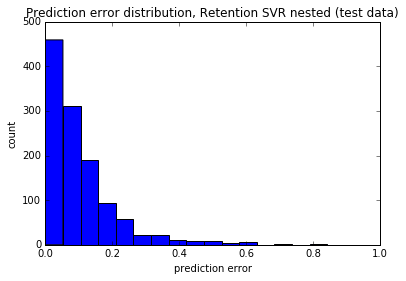

In [31]:
hist_plot_delta(SVR_nested, X_test[:,:19], y_test[:,:19], model_name='SVR nested (test data)', nested=True)
# hist_plot_delta(SVR_nested, X_train, y_train, model_name='SVR nested (train data)')

### Error distribution comparison between models

The following histogram plots show how different models perform. Even though some models have similar R2 and MAE, they don't always make the same prediction. This comparison shows how the models trade off error distribution.

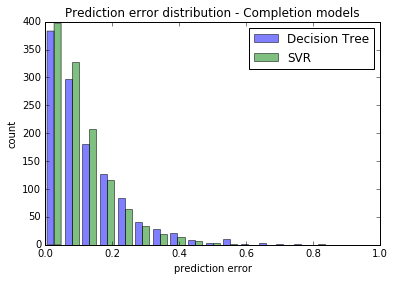

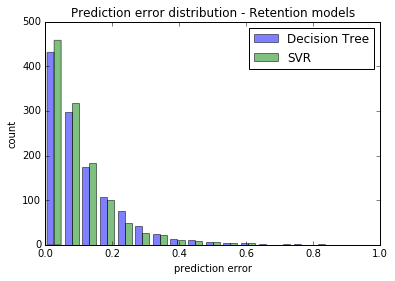

In [32]:
compare_hist_plot_delta(DT19_model, SVR19_model, X_test[:,:19], y_test[:,:19], ['Decision Tree', 'SVR'])

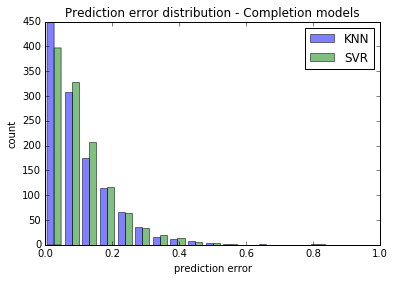

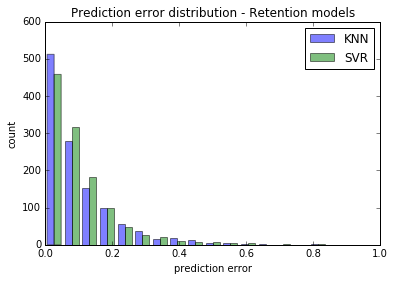

In [33]:
compare_hist_plot_delta(KNN19_model, SVR19_model, X_test[:,:19], y_test[:,:19], ['KNN', 'SVR'])

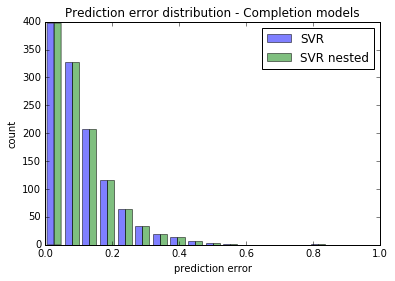

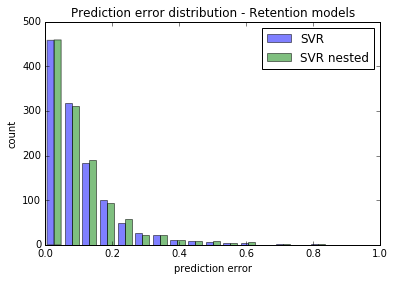

In [34]:
compare_hist_plot_delta(SVR19_model, SVR_nested, X_test[:,:19], y_test[:,:19], ['SVR', 'SVR nested'], nested=[False, True])